In [1]:
import shutil

from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False


In [2]:
species = "k_pneumoniae"

plasmid_cut_off = 1000000


In [35]:
plt.rc("font", size=16)
plt.rc("axes", titlesize=16)
plt.rc("axes", labelsize=16)
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("legend", fontsize=16)
plt.rc("figure", titlesize=16)


get contig information from __hybrid assembly__

In [36]:
assembly_fasta_files = glob("../data/hybrid_assembly_fasta_files/" + species + "/*")


In [37]:
dict_isolate_dict_contig_information = {}

for assembly_fasta_file in assembly_fasta_files:

    isolate = assembly_fasta_file.split("\\")[-1].split(".")[0]

    temp_file = open(assembly_fasta_file, "r")
    lines = temp_file.readlines()
    temp_file.close()

    # labelling:
    # contig length > plasmid_cut_off and circular --> chromosome
    # contig length <= plasmid_cut_off and circular --> plasmid

    dict_contig_length_circular_label = {}

    for line in lines:
        if line.startswith(">"):
            contig = line[1:].split()[0]
            length = int(line.split()[1].split("=")[1])
            circular = "circular=true" in line

            if length > plasmid_cut_off:
                label = "chromosome"
            elif length <= plasmid_cut_off and circular:
                label = "plasmid"
            else:
                label = "no_label"

            dict_contig_length_circular_label[int(contig)] = (length, circular, label)

    dict_isolate_dict_contig_information[isolate] = dict_contig_length_circular_label


Draw distribution of circular contigs in __hybrid assembly__

In [38]:
num_circular_contigs = []
for isolate in dict_isolate_dict_contig_information:
    circular_contigs = len(
        [
            key
            for key in dict_isolate_dict_contig_information[isolate]
            if dict_isolate_dict_contig_information[isolate][key][1] == True
        ]
    )
    # print(isolate, "circular hybrid contigs:", circular_contigs)
    num_circular_contigs.append(circular_contigs)


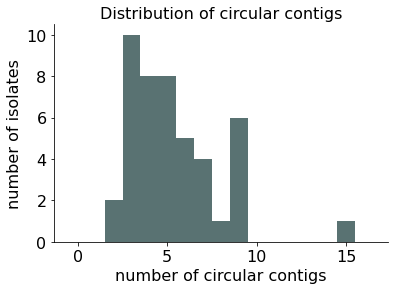

In [39]:
max_circular_contigs = max(num_circular_contigs)

plt.hist(
    num_circular_contigs,
    alpha=0.8,
    bins=np.arange(-0.5, max_circular_contigs + 2.5, 1),
    color="darkslategrey",
)

plt.title("Distribution of circular contigs")
plt.xlabel("number of circular contigs")
plt.ylabel("number of isolates")
plt.savefig(
    "../results/figures/"
    + species
    + "_distribution_of_circular_contigs_in_hybrid_assembly.png",
    dpi=600,
    format="png",
    bbox_inches="tight",
)
plt.show()
plt.clf()
plt.close()


In [40]:
circular_contig_lengths = []

for isolate in dict_isolate_dict_contig_information:
    for contig in dict_isolate_dict_contig_information[isolate]:
        if dict_isolate_dict_contig_information[isolate][contig][1] == True:
            circular_contig_lengths.append(
                dict_isolate_dict_contig_information[isolate][contig][0]
            )


In [41]:
max_circular_contig_length = max(circular_contig_lengths)
print("longest circular contig in bp:", max_circular_contig_length)


longest circular contig in bp: 5511072


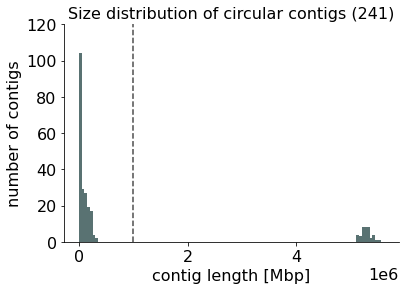

In [44]:
plt.hist(
    circular_contig_lengths,
    alpha=0.8,
    bins=np.arange(0, max_circular_contig_length + 100000, 50000),
    color="darkslategrey",
)
plt.plot([plasmid_cut_off, plasmid_cut_off], [0, 120], "--", c="black", alpha=0.7)

plt.title(
    "Size distribution of circular contigs (" + str(len(circular_contig_lengths)) + ")"
)
plt.ylim(0, 120)
plt.xlabel("contig length [Mbp]")
plt.ylabel("number of contigs")
plt.savefig(
    "../results/figures/" + species + "_size_distribution_of_circular_contigs.png",
    dpi=600,
    format="png",
    bbox_inches="tight",
)
plt.show()
plt.clf()
plt.close()


In [45]:
# plot distribution of non circular contigs

non_circular_contig_lengths = []

for isolate in dict_isolate_dict_contig_information:
    for contig in dict_isolate_dict_contig_information[isolate]:
        if dict_isolate_dict_contig_information[isolate][contig][1] == False:
            non_circular_contig_lengths.append(
                dict_isolate_dict_contig_information[isolate][contig][0]
            )


In [46]:
max_non_circular_contig_length = max(non_circular_contig_lengths)
print("longest non circular contig in bp:", max_non_circular_contig_length)


longest non circular contig in bp: 5462321


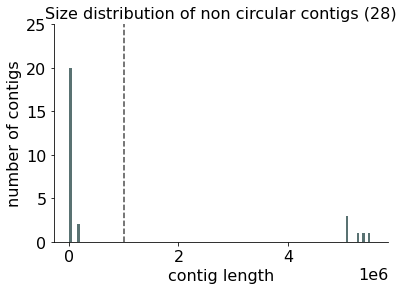

In [50]:
plt.hist(
    non_circular_contig_lengths,
    alpha=0.8,
    bins=np.arange(0, max_non_circular_contig_length + 100000, 50000),
    color="darkslategrey",
)
plt.plot([plasmid_cut_off, plasmid_cut_off], [0, 25], "--", c="black", alpha=0.7)

plt.title(
    "Size distribution of non circular contigs ("
    + str(len(non_circular_contig_lengths))
    + ")"
)
plt.ylim(0, 25)
plt.xlabel("contig length")
plt.ylabel("number of contigs")
plt.savefig(
    "../results/figures/" + species + "_size_distribution_of_non_circular_contigs.png",
    dpi=600,
    format="png",
    bbox_inches="tight",
)
plt.show()
plt.clf()
plt.close()


Get minimap alignment information and label __short read contigs__

In [51]:
# generate ambiguity_constant, 1 means that the contig is only ambiguous
# if it maps with the same number of residues on plasmid and chromosome contigs.
# 0.9 would mean that that only 90% from the maximal match has to be reached to get labelled ambiguous
ambiguity_constant = 1


In [52]:
alignment_files = glob("../data/alignment_files/" + species + "/*alignment.paf")


In [53]:
# add labels to alignment.tsv
for alignment_file in alignment_files:

    # get isolate
    isolate = alignment_file.split("\\")[-1].split("_")[0]

    # read df (only columns of interes)
    df = pd.read_csv(alignment_file, sep="\t", header=None, usecols=[0, 1, 5, 6, 9])

    # rename columns with minimap output column names (https://github.com/lh3/miniasm/blob/master/PAF.md)
    df.columns = [
        "short_read_contig_id",
        "short_read_contig_length",
        "mapped_against_hybrid_contig_id",
        "hybrid_contig_length",
        "number_of_residue_matches",
    ]

    # drop duplicates (same short read contig mapped to same hybrid contig)
    df = df.drop_duplicates(
        subset=["short_read_contig_id", "mapped_against_hybrid_contig_id"], keep="first"
    )

    # add columns to dataframe from dict
    df["temp"] = df["mapped_against_hybrid_contig_id"].map(
        dict_isolate_dict_contig_information[isolate]
    )

    # split tuple column
    df[["length", "is_circular", "label"]] = pd.DataFrame(
        df["temp"].tolist(), index=df.index
    )

    # dropt temp column
    df = df.drop(["temp", "length"], axis=1)

    # generate list of lists for df with "ambiguous" label
    list_of_lists_for_new_df = []

    # iterate over rows and check ambiguity of contig
    for index, row in df.iterrows():
        # extract information
        short_read_contig_id = row["short_read_contig_id"]
        short_read_contig_length = row["short_read_contig_length"]
        number_of_residue_matches = row["number_of_residue_matches"]

        df_single_contig = df[df["short_read_contig_id"] == short_read_contig_id]
        if len(df_single_contig) == 1:
            # only one entry - not ambiguous
            list_of_lists_for_new_df.append(df_single_contig.iloc[0].to_list())
        else:
            # more than one entry - check ambiguity
            # extract max number of matches
            max_residue_matches = max(df_single_contig["number_of_residue_matches"])
            # extract all alignments that are ambiguous according to the ambiguity_constant
            ambiguous_contigs_df = df_single_contig[
                df_single_contig["number_of_residue_matches"]
                >= max_residue_matches * ambiguity_constant
            ]
            # extract all labels of ambiguous contigs
            matched_labels = ambiguous_contigs_df["label"].to_list()
            # add new row to df
            if "chromosome" in matched_labels and "plasmid" in matched_labels:
                list_of_lists_for_new_df.append(
                    [
                        short_read_contig_id,
                        short_read_contig_length,
                        "NA",
                        "NA",
                        max_residue_matches,
                        "NA",
                        "ambiguous",
                    ]
                )
            elif (
                "chromosome" in matched_labels or "plasmid" in matched_labels
            ) and "no_label" in matched_labels:
                list_of_lists_for_new_df.append(
                    ambiguous_contigs_df[ambiguous_contigs_df["label"] == "no_label"]
                    .iloc[0]
                    .to_list()
                )
            else:  # take best hit
                list_of_lists_for_new_df.append(df_single_contig.iloc[0].to_list())

    # generate final df
    cols = df.columns
    df = pd.DataFrame(list_of_lists_for_new_df, columns=cols)
    df = df.drop_duplicates(keep="first")

    # write to csv
    df.to_csv(
        alignment_file[:-4]
        + "_labelled"
        + "_ambiguity_cutoff_"
        + str(ambiguity_constant)
        + ".csv",
        index=False,
    )


Check if samples have more than 95% of contigs labelled and discard such samples

In [54]:
labelled_alignment_files = glob(
    "../data/alignment_files/"
    + species
    + "/*alignment_labelled_ambiguity_cutoff_1.csv"
)


In [55]:
isolates_to_discard = []

for file_ in labelled_alignment_files:
    df = pd.read_csv(file_)
    if (len(df[df["label"] == "no_label"]) / len(df)) > 0.05:
        isolate = "_".join(file_.split("\\")[-1].split("_")[0:-5])
        isolates_to_discard.append(isolate)
        print(isolate)


In [32]:
# move isolates to discarded folder
for isolate in isolates_to_discard:
    files_to_discard = glob("../data/*/" + species + "/" + isolate + "*")
    for file_ in files_to_discard:
        shutil.move(file_, "../data/discarded_files/")


Visualize distribution of labelled contigs

In [3]:
labelled_alignment_files = glob(
    "../data/alignment_files/"
    + species
    + "/*alignment_labelled_ambiguity_cutoff_1.csv"
)


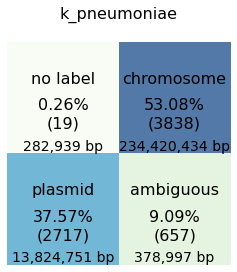

In [4]:
no_label = 0
ambiguous = 0
chromosome = 0
plasmid = 0

no_label_length = 0
ambiguous_length = 0
chromosome_length = 0
plasmid_length = 0

for csv_file in labelled_alignment_files:

    df = pd.read_csv(csv_file)

    no_label += len(df[df["label"] == "no_label"])
    ambiguous += len(df[df["label"] == "ambiguous"])
    chromosome += len(df[df["label"] == "chromosome"])
    plasmid += len(df[df["label"] == "plasmid"])

    no_label_length += df[df["label"] == "no_label"]["short_read_contig_length"].sum()
    ambiguous_length += df[df["label"] == "ambiguous"]["short_read_contig_length"].sum()
    chromosome_length += df[df["label"] == "chromosome"]["short_read_contig_length"].sum()
    plasmid_length += df[df["label"] == "plasmid"]["short_read_contig_length"].sum()


total_num_contigs = no_label + ambiguous + chromosome + plasmid

matrix = [[no_label, chromosome], [plasmid, ambiguous]]

plt.matshow(matrix, cmap="GnBu", alpha=0.7)

for (i, j), z in np.ndenumerate(matrix):
    plt.text(
        j,
        i,
        str(round((z / total_num_contigs) * 100, 2)) + "%",
        ha="center",
        va="top",
        fontsize=16,
    )

plt.text(0, -0.1, "no label", ha="center", va="bottom", fontsize=16)
plt.text(0, 0.3, "(" + str(no_label) + ")", ha="center", va="bottom", fontsize=16)
plt.text(0, 0.5, f'{no_label_length:,}' + " bp", ha="center", va="bottom", fontsize=14)

plt.text(0, 0.9, "plasmid", ha="center", va="bottom", fontsize=16)
plt.text(0, 1.3, "(" + str(plasmid) + ")", ha="center", va="bottom", fontsize=16)
plt.text(0, 1.5, f'{plasmid_length:,}' + " bp", ha="center", va="bottom", fontsize=14)


plt.text(1, -0.1, "chromosome", ha="center", va="bottom", fontsize=16)
plt.text(1, 0.3, "(" + str(chromosome) + ")", ha="center", va="bottom", fontsize=16)
plt.text(1, 0.5, f'{chromosome_length:,}' + " bp", ha="center", va="bottom", fontsize=14)


plt.text(1, 0.9, "ambiguous", ha="center", va="bottom", fontsize=16)
plt.text(1, 1.3, "(" + str(ambiguous) + ")", ha="center", va="bottom", fontsize=16)
plt.text(1, 1.5, f'{ambiguous_length:,}' + " bp", ha="center", va="bottom", fontsize=14)


plt.axis("off")

plt.title(species, fontsize=16)
plt.savefig(
    "../results/figures/" + species + "_short_read_contig_label_distribution.png",
    dpi=600,
    format="png",
    bbox_inches="tight",
)
plt.show()
plt.clf()
plt.close()
